In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import json
import sklearn
%matplotlib inline

#sklearn library
# 1.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold

# 2.preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

# 3.metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 4.model
import lightgbm as lgb
# from bayes_opt import BayesianOptimization

# 5.plot
# import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

In [4]:
font = {'family':'Helvetica, Ariel',
        'weight':'normal',
        'size':12}
plt.rc('font', **font)
sns.set_context('notebook')
sns.set_style("ticks")
FIG_FONT = dict(family="Helvetica, Ariel", weight="bold", color="#7f7f7f")
sns.set_palette("Spectral")

In [6]:
df = pd.read_csv('data.csv')
df.head(3)
# df.info()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [7]:
df.diagnosis=[1 if i =='M' else 0 for i in df.diagnosis.values]
df.drop(['Unnamed: 32','id'],axis=1,inplace=True)

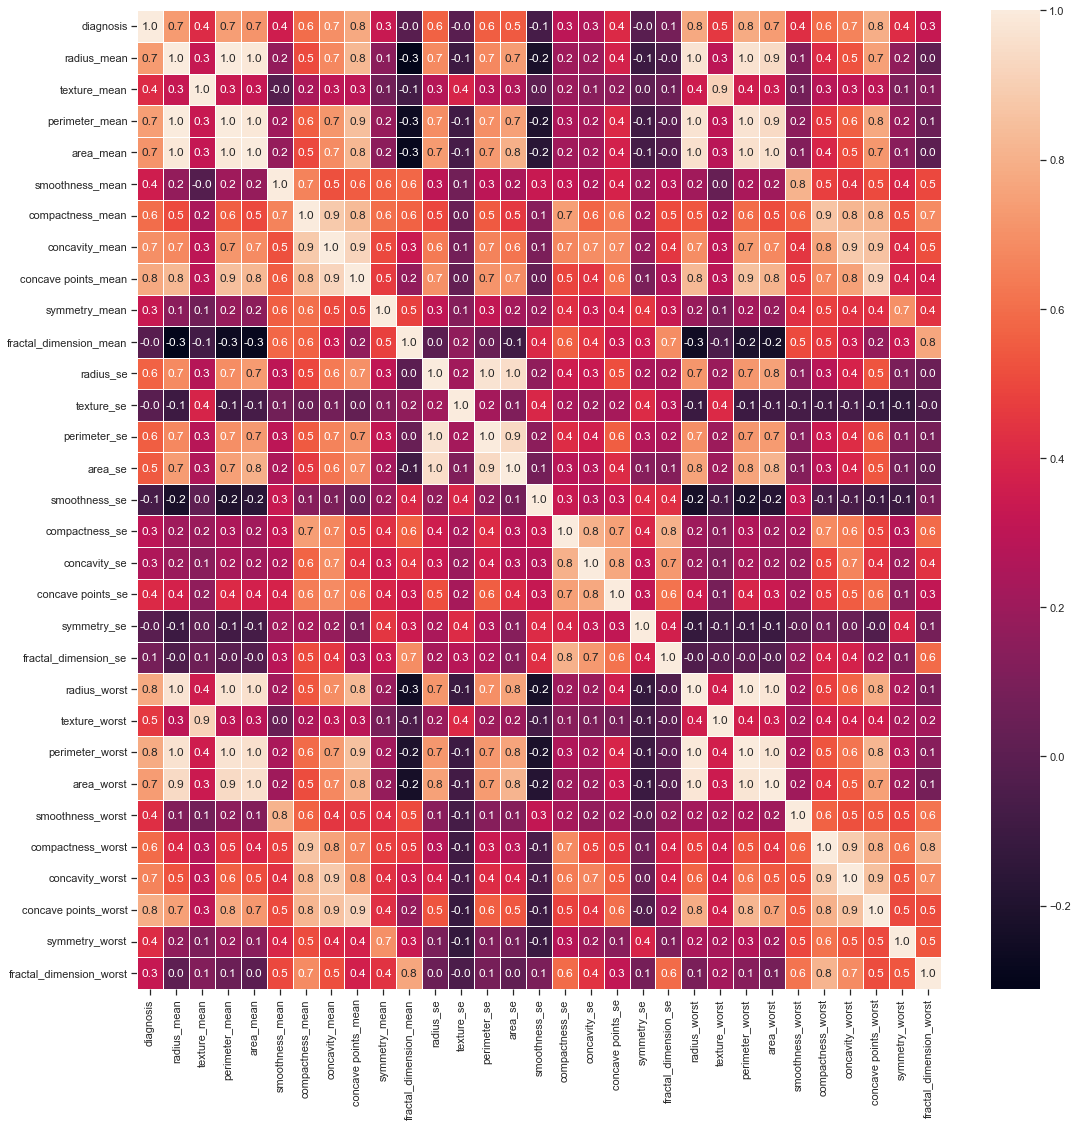

In [8]:
fig,ax = plt.subplots(figsize=(18, 18))
axes = sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [9]:
#Simply select the features with a correlation>0.5 with diagnosis
features = list(df.corr()[df.corr()['diagnosis']>0.5].index)
X=df[features]

No handles with labels found to put in legend.


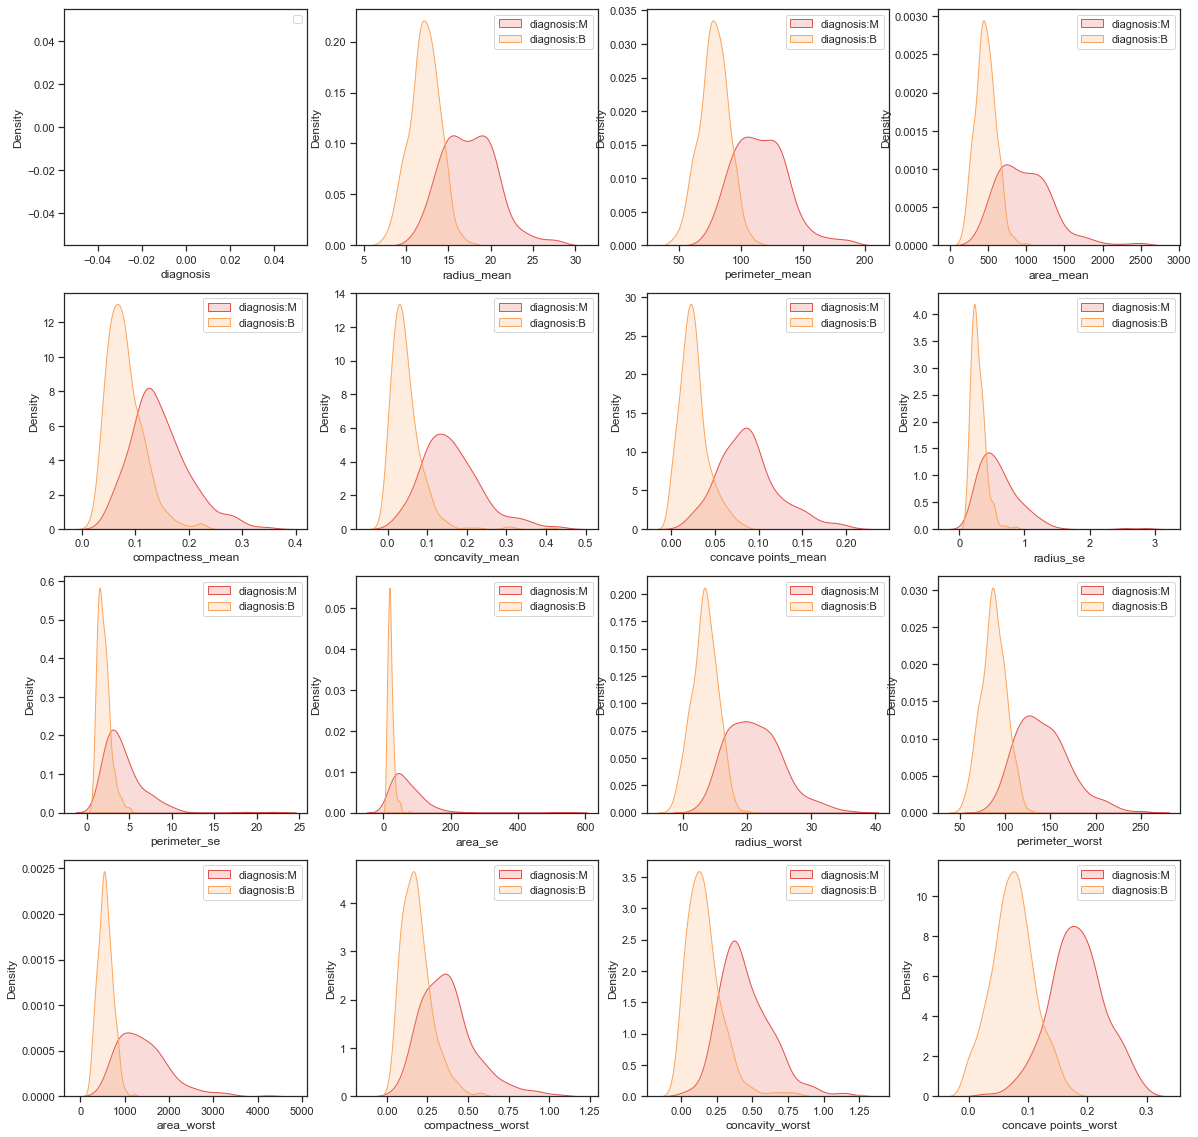

In [10]:
fig, axes = plt.subplots(4,4,figsize=(20,20))

cnt = 0
for i in range(4):
    for j in range(4):
        feature_element = features[cnt]
        cnt+=1
        plt.sca(axes[i,j])
        sns.kdeplot(df[df.diagnosis==1][feature_element],shade=True,alpha=0.2,legend=True,label='diagnosis:M')
        sns.kdeplot(df[df.diagnosis==0][feature_element],shade=True,alpha=0.2,legend=True,label='diagnosis:B')
        plt.legend()

In [11]:
def process_df(df):    
    #1、Handling null values 
    df=df.dropna()
    
    #2、create y value by using "diagnosis", convert to int type 
    target=df.diagnosis
    df=df[features]
                                                 
    #3、Create the training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, 
                                                    random_state=100,stratify=target)
    
    #4、Obtaining continuous variable 
    numaric_columns=list(df.select_dtypes(include=np.number).columns)
    print("Numaric columns ("+str(len(numaric_columns))+") :",", ".join(numaric_columns))
    
    #5、Obtaining discrete variables 
    cat_columns=df.select_dtypes(include=['object']).columns.tolist()
    print("Categorical columns ("+str(len(cat_columns))+") :",", ".join(cat_columns))
    
    
    #6、Using continuous variable training data 
    X_train_n=X_train[numaric_columns].copy()
    X_test_n=X_test[numaric_columns].copy()
    scaler = MinMaxScaler()
    X_train_n_index = X_train_n.index
    X_test_n_index = X_test_n.index
    
    X_train_n = scaler.fit_transform(X_train_n)
    X_train_n = pd.DataFrame(X_train_n,index=X_train_n_index,columns = numaric_columns)
    
    X_test_n = scaler.transform(X_test_n)
    X_test_n = pd.DataFrame(X_test_n,index=X_test_n_index,columns = numaric_columns)

    #7、Using discrete variable training data 
    X_train_c=X_train[cat_columns]
    X_test_c=X_test[cat_columns]
                               
    #8、Ordinal label processing for discrete variables 
    encoder=OrdinalEncoder()
    X_train_c = encoder.fit_transform(X_train_c)
    
    X_train_c=pd.DataFrame(X_train_c,index=X_train_n.index)
    X_test_c = encoder.transform(X_test_c)
    X_test_c=pd.DataFrame(X_test_c,index=X_test_n.index)
    
    #9、Merge together
    for i,column in enumerate(X_train_c.columns):
        X_train_n["cat_"+str(i+1)]=X_train_c[column]
        X_test_n["cat_"+str(i+1)]=X_test_c[column]

    return X_train_n, X_test_n, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = process_df(df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Numaric columns (16) : diagnosis, radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, concave points_mean, radius_se, perimeter_se, area_se, radius_worst, perimeter_worst, area_worst, compactness_worst, concavity_worst, concave points_worst
Categorical columns (0) : 
(455, 16) (114, 16) (455,) (114,)


In [13]:
y_train.value_counts()
# X_train.columns

0    285
1    170
Name: diagnosis, dtype: int64

In [17]:
# import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

train_df = X_train
test_df = X_test
target = 'diagnosis'
predictors = train_df.columns.values.tolist()[1:]
bayesian_tr_index, bayesian_val_index = list(StratifiedKFold(n_splits=2,
                                                             shuffle=True, random_state=1).split(train_df, train_df.diagnosis.values))[0]

In [18]:
def LGB_bayesian(
#     num_boost_round,
    num_leaves, 
    min_data_in_leaf, 
    learning_rate,
    min_sum_hessian_in_leaf, 
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth,
#     early_stopping_rounds
):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    
    # setting by experience
    num_boost_round = 1000
    num_boost_round = int(num_boost_round)
    early_stopping_rounds = 50
    early_stopping_rounds = int(early_stopping_rounds)
    
    param = {
        'num_boost_round':num_boost_round,
        'num_leaves': num_leaves,
#         'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True,
        'seed': 123,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        #'verbose': 1,
        'verbosity': -1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
#         'early_stopping_rounds': 50
    }
    xg_train = lgb.Dataset(train_df.iloc[bayesian_tr_index][predictors].values,
                           label=train_df.iloc[bayesian_tr_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False)
    xg_valid = lgb.Dataset(train_df.iloc[bayesian_val_index][predictors].values,
                           label=train_df.iloc[bayesian_val_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False)

    clf = lgb.train(param, 
                    num_boost_round = num_boost_round,
                    early_stopping_rounds = early_stopping_rounds,
                    train_set = xg_train,
                    valid_sets = [xg_valid],
                    verbose_eval=250)
    predictions = clf.predict(train_df.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)
    score = metrics.roc_auc_score(train_df.iloc[bayesian_val_index][target].values, predictions)
    return score

In [19]:
X_train = X_train[predictors]
X_test = X_test[predictors]

In [20]:
bounds_LGB = {
#     'num_boost_round':(100,5000),
    'num_leaves': (5, 20),
    'min_data_in_leaf': (5, 20),
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0),
    'lambda_l2': (0, 5.0),
    'min_gain_to_split': (0, 1.0),
    'max_depth':(2,6),
#     'early_stopping_rounds':(50,200)
}

In [21]:
from bayes_opt import BayesianOptimization

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=123)
print(LGB_BO.space.keys)

import warnings
from sklearn import metrics
init_points = 5
n_iter = 5
print('-' * 130)
LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

['feature_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']
----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.985315
|  1        |  0.9853   |  0.3634   |  1.431    |  1.134    |  0.1699   |  4.878    |  11.35    |  0.9808   |  0.006851 |  12.21    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.982435
|  2        |  0.9824   |  0.2265   |  1.716    |  3.645  

In [22]:
LGB_BO.max['target']

0.9853146853146854

In [23]:
LGB_BO.max['params']

{'feature_fraction': 0.36341113351903775,
 'lambda_l1': 1.4306966747518972,
 'lambda_l2': 1.1342572678210154,
 'learning_rate': 0.16988128303403846,
 'max_depth': 4.877875879142252,
 'min_data_in_leaf': 11.346596901866913,
 'min_gain_to_split': 0.9807641983846155,
 'min_sum_hessian_in_leaf': 0.006851449088462784,
 'num_leaves': 12.213978522265414}

In [24]:
for key,value in LGB_BO.max['params'].items():
    if key in ['max_depth','min_data_in_leaf','num_leaves']:
        print(key,'=int(',value,'),')
    else:
        print(key,'=',value,',')

feature_fraction = 0.36341113351903775 ,
lambda_l1 = 1.4306966747518972 ,
lambda_l2 = 1.1342572678210154 ,
learning_rate = 0.16988128303403846 ,
max_depth =int( 4.877875879142252 ),
min_data_in_leaf =int( 11.346596901866913 ),
min_gain_to_split = 0.9807641983846155 ,
min_sum_hessian_in_leaf = 0.006851449088462784 ,
num_leaves =int( 12.213978522265414 ),


Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0921366	valid_1's binary_logloss: 0.134313
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0921366	valid_1's binary_logloss: 0.134313


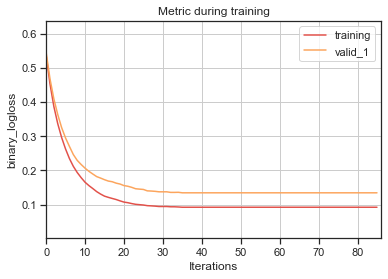

In [25]:
# setting by LGB_BO.max['params']
param = {'boosting_type':'gbdt','objective':'binary','metric':'binary_logloss',
    'num_boost_round':1000,
    'feature_fraction': 0.36341113351903775,
    'lambda_l1': 1.4306966747518972,
    'lambda_l2': 1.1342572678210154,
    'learning_rate': 0.16988128303403846,
    'max_depth':int( 4.877875879142252),
    'min_data_in_leaf': int( 11.346596901866913 ),
    'min_gain_to_split': 0.9807641983846155,
    'min_sum_hessian_in_leaf': 0.006851449088462784,
    'num_leaves': int( 12.213978522265414 ),
#     'num_class': 2,
    'early_stopping_rounds':50,
    'verbose': -1}

evals_result = {}  


train_data = lgb.Dataset(X_train, label = y_train)  
test_data = lgb.Dataset(X_test, label = y_test,reference=train_data)

model = lgb.train(param,      
                  train_data,      
                  valid_sets=[train_data,test_data],
                  evals_result=evals_result, # Record the calculated value of loss function in each round     
                  #verbose_eval=False) # How many rounds to output a training result,True/False/number      
                  verbose_eval=50)  
# print(params)  
# Draw the loss curve with the recorded loss function value  
lgb.plot_metric(evals_result, metric='binary_logloss') # The metric value corresponds to the previous params  
plt.show()    

In [26]:
from sklearn import metrics
model=lgb.LGBMClassifier(
    boosting_type='gbdt',objective='binary',metrics='logloss',
    feature_fraction = 0.36341113351903775 ,
    lambda_l1 = 1.4306966747518972 ,
    lambda_l2 = 1.1342572678210154 ,
    learning_rate = 0.16988128303403846 ,
    max_depth =int( 4.877875879142252 ),
    min_data_in_leaf =int( 11.346596901866913 ),
    min_gain_to_split = 0.9807641983846155 ,
    min_sum_hessian_in_leaf = 0.006851449088462784 ,
    num_leaves =int( 12.213978522265414 ),
    num_class = 1)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("acc:",metrics.accuracy_score(y_test,y_test_pred))
print("auc:",metrics.roc_auc_score(y_test,y_test_pred))

acc: 0.9473684210526315
auc: 0.9533730158730159


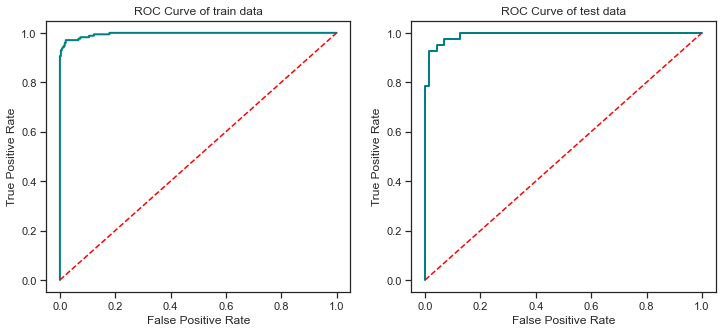

In [28]:
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test, y_test_pred_prob)

fig,axes = plt.subplots(1,2,figsize=(12,5))

plt.sca(axes[0])
plt.plot(fpr_train, tpr_train, linewidth=2, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve of train data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.sca(axes[1])
plt.plot(fpr_test, tpr_test, linewidth=2, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve of test data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [30]:
### Create a Pickle file using serialization 
import pickle
pickle_out = open("model.pkl","wb")
pickle.dump(model, pickle_out)
pickle_out.close()